In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import numpy as np

In [2]:
# Function that creates unique id for each node

def generate_node_id(node_ids):
    new_id = random.randint(1, 1e5)
    while new_id in node_ids:
        new_id = random.randint(1, 1e5)
    node_ids.add(new_id)
    return new_id

In [3]:
# Function that split the data according the given center

def split_data(data, axis):
    means = np.mean(np.array(data), axis=0)
    if(axis==0):
        return (data[data[:, 0] < means[0]], data[data[:, 0] >= means[0]])
    elif(axis==1):
        return (data[data[:, 1] < means[1]], data[data[:, 1] >= means[1]])
    else:
        return (data[data[:, 2] < means[2]], data[data[:, 2] >= means[2]])

In [4]:
# State capture per density_threshold

# By capturing the tree structure at each threshold, 
# you can see how features like connected components emerge, evolve, and disappear.
# This provides insights into the tree's resilience, adaptability, and the significance of its structural features.
# In the case of tree data structure, there is no hole so only connected dots (B_0) is considered

# Depth Threshold

depth_threshold = 3

# Degree/Density Threshold

density_thresholds = list(range(0, 4097, 16)) # [0, 16, 32, ..., 4096]

In [5]:
node_ids = set() # Temp Store for unique node id
all_splits = {} # Temp Store for displayal

# Deterministic K-D Tree

def build_kdtree(data, source_id, depth, density_threshold, betti_0, kdtree):
    
    # Base case
    if depth >= depth_threshold or len(data) == 0:
        return betti_0, kdtree
    
    # Axis is pre-determined (by the depth)
    # Use `depth` to cut in the x-, y- ,z- axis order
    # Use `2-depth` to cut in the z-, y- ,x- axis order
    
    axis = 2-depth
    
    left_data, right_data = split_data(data, axis)
    
    global all_splits
    
    all_splits[ (depth, axis, 0, generate_node_id(node_ids)) ] = left_data 
    all_splits[ (depth, axis, 1, generate_node_id(node_ids)) ] = right_data
    
    # Increase depth
    
    depth += 1

    for subdivision in [left_data, right_data]:
        num_points_in_box = len(subdivision)
        target_id = generate_node_id(node_ids)

        box = [num_points_in_box, depth, source_id, target_id]
        
        if num_points_in_box > density_threshold:
            kdtree.append(box)
            betti_0, kdtree = build_kdtree(subdivision, target_id, depth, density_threshold, betti_0, kdtree)
        else:
            betti_0 += 1

    return betti_0, kdtree

### $Betti_0$ Change in House Point Clouds Across K-D Tree Density Thresholds

In [6]:
# Reset for Space

node_ids = set()
all_splits = {}

# Read the data for House Random

data_random = pd.read_csv('data/House/csv/random/house_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random.sort_values(by=['X', 'Y', 'Z'])
data_random = data_random.to_numpy()
house_random_betti_0s = []

# density_threshold = 0
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    house_random_betti_0s.append(betti_0)

In [7]:
# # Output XYZ file to see how split is performed

# keys = all_splits.keys()

# for key in keys:
#     file = 'depth' + str(key[0]) + '_axis' + str(key[1]) + '_child' + str(key[2]) + '_id' + str(key[3]) + '.XYZ'
#     pd.DataFrame(all_splits[key], columns=['X', 'Y', 'Z']).to_csv('view_split/House/random/' + file, index=False)

In [8]:
# Reset for Space

node_ids = set()
all_splits = {}

# Read the data for House Spatial

data_spatial = pd.read_csv('data/House/csv/spatial/house_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial.sort_values(by=['X', 'Y', 'Z'])
data_spatial = data_spatial[['X', 'Y', 'Z']].to_numpy()
house_spatial_betti_0s = []

# density_threshold = 0
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    house_spatial_betti_0s.append(betti_0)

In [9]:
# # Output XYZ file to see how split is performed

# keys = all_splits.keys()

# for key in keys:
#     file = 'depth' + str(key[0]) + '_axis' + str(key[1]) + '_child' + str(key[2]) + '_id' + str(key[3]) + '.XYZ'
#     pd.DataFrame(all_splits[key], columns=['X', 'Y', 'Z']).to_csv('view_split/House/spatial/' + file, index=False)

### Variances of Among the Two Distributions

In [10]:
var_house_random = np.var(np.array(house_random_betti_0s))
var_house_spatial = np.var(np.array(house_spatial_betti_0s))

print(var_house_random, var_house_spatial)

4.346167239473726 3.821011673151751


### Wasserstein Distance Between the Two Distributions

In [11]:
was_dis_house = wasserstein_distance(house_random_betti_0s, house_spatial_betti_0s)

print(was_dis_house)

0.2607003891050584


### $Betti_0$ Change in Tree Point Clouds Across K-D Tree Density Thresholds

In [12]:
# Read the data for Tree Random

node_ids = set()

data_random = pd.read_csv('data/Tree/csv/random/tree_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random.sort_values(by=['X', 'Y', 'Z'])
data_random = data_random[['X', 'Y', 'Z']].to_numpy()
tree_random_betti_0s = []

# density_threshold = 0 
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    tree_random_betti_0s.append(betti_0)

In [13]:
# Read the data for Tree Spatial

node_ids = set()

data_spatial = pd.read_csv('data/Tree/csv/spatial/tree_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial.sort_values(by=['X', 'Y', 'Z'])
data_spatial = data_spatial[['X', 'Y', 'Z']].to_numpy()
tree_spatial_betti_0s = []

# density_threshold = 0
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    tree_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [14]:
var_tree_random = np.var(np.array(tree_random_betti_0s))
var_tree_spatial = np.var(np.array(tree_spatial_betti_0s))

print(var_tree_random, var_tree_spatial)

4.3890444972671805 4.37348029493255


### Wasserstein Distance Between the Two Distributions

In [15]:
was_dis_tree = wasserstein_distance(tree_random_betti_0s, tree_spatial_betti_0s)
print(was_dis_tree)

0.046692607003891134


### $Betti_0$ Change in Light Pole Point Clouds Across K-D Tree Density Thresholds

In [16]:
# Read the data for Light Pole Random

node_ids = set()

data_random = pd.read_csv('data/LightPole/csv/random/lightpole_random.csv', sep=',')[['X', 'Y', 'Z']]
data_random = data_random.sort_values(by=['X', 'Y', 'Z'])
data_random = data_random[['X', 'Y', 'Z']].to_numpy()
lightpole_random_betti_0s = []

# density_threshold = 0
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    lightpole_random_betti_0s.append(betti_0)

In [17]:
# Read the data for Light Pole Spatial

node_ids = set()

data_spatial = pd.read_csv('data/LightPole/csv/spatial/lightpole_spatial.csv', sep=',')[['X', 'Y', 'Z']]
data_spatial = data_spatial.sort_values(by=['X', 'Y', 'Z'])
data_spatial = data_spatial[['X', 'Y', 'Z']].to_numpy()
lightpole_spatial_betti_0s = []

# density_threshold = 0
for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    kdtree = [] # for storing the whole kdtree
    betti_0, kdtree = build_kdtree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       kdtree)
    lightpole_spatial_betti_0s.append(betti_0)

### Variances of Among the Two Distributions

In [18]:
var_lightpole_random = np.var(np.array(lightpole_random_betti_0s))
var_lightpole_spatial = np.var(np.array(lightpole_spatial_betti_0s))

print(var_lightpole_random, var_lightpole_spatial)

1.4551923571893597 1.435782525095005


### Wasserstein Distance Between the Two Distributions

In [19]:
was_dis_lightpole = wasserstein_distance(lightpole_random_betti_0s, lightpole_spatial_betti_0s)
print(was_dis_lightpole)

0.01167315175097279


### Visualizations of $Betti_0$ Change For All Input Data

### ... if the cutting order is in x,y,z-axis

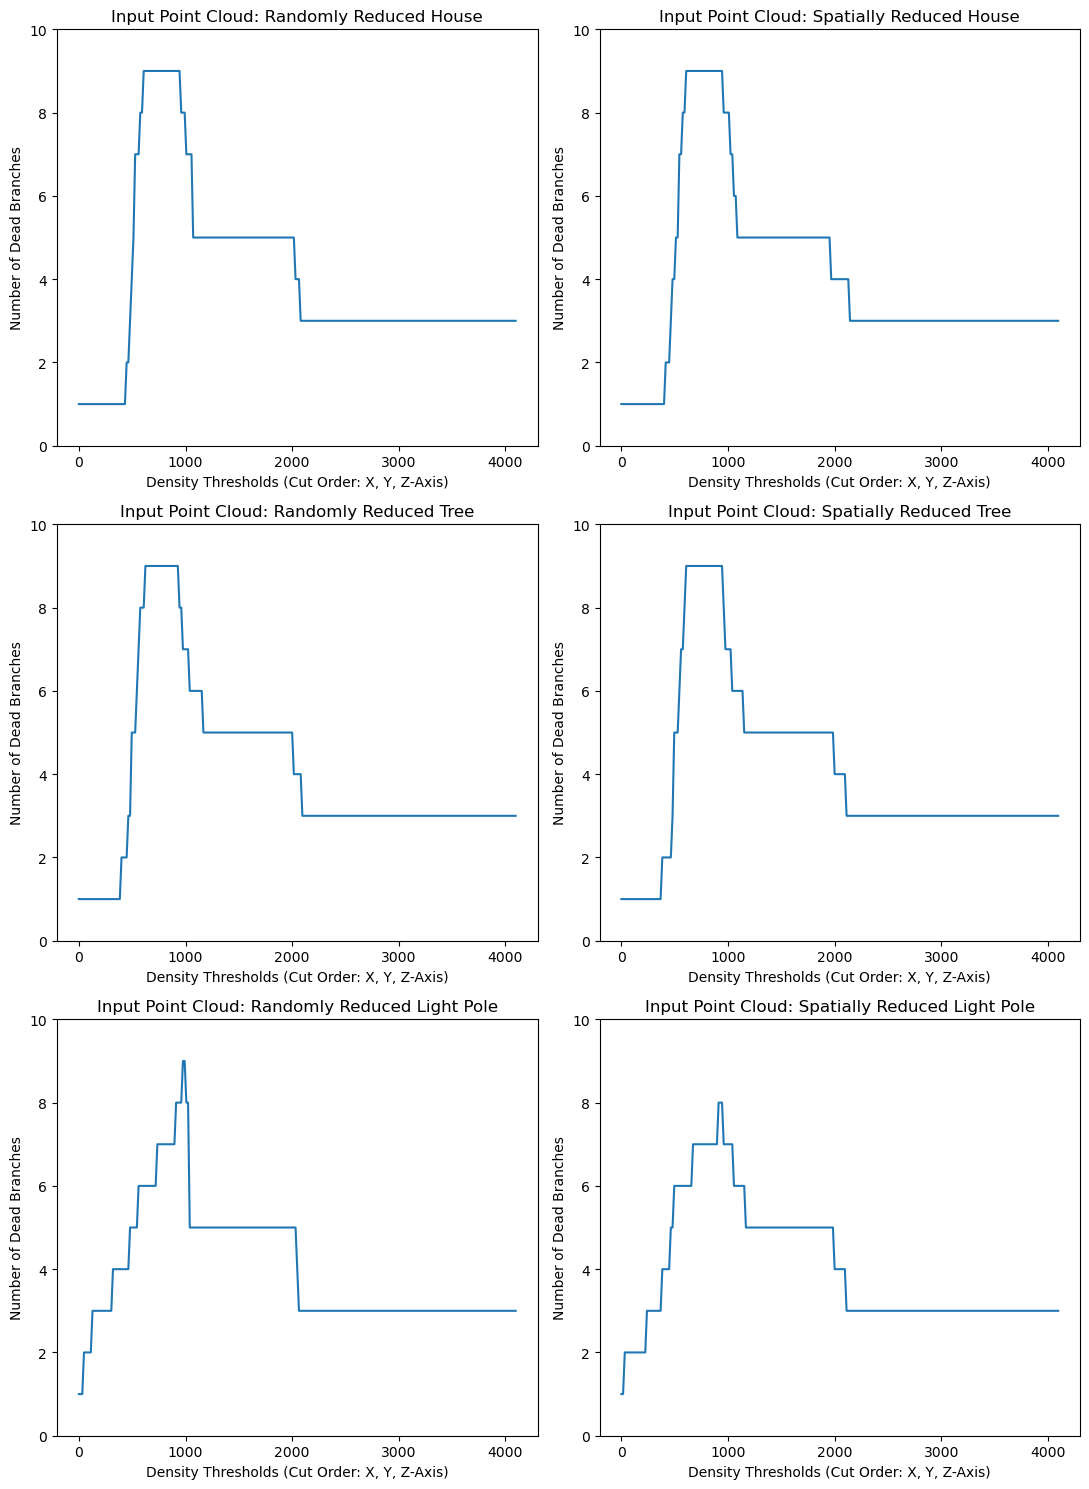

In [20]:
# Determine the global min and max y-values

# min_val = min([min(house_random_betti_0s), min(house_spatial_betti_0s), \
#            min(tree_random_betti_0s), min(tree_spatial_betti_0s), \
#            min(lightpole_random_betti_0s), min(lightpole_random_betti_0s)])
min_val = 0

# max_val = max([max(house_random_betti_0s), max(house_spatial_betti_0s), \
#            max(tree_random_betti_0s), max(tree_spatial_betti_0s), \
#            max(lightpole_random_betti_0s), max(lightpole_random_betti_0s)])
max_val = 10

# Create plot

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 15))

# Plot for House Random
axs[0,0].plot(density_thresholds, house_random_betti_0s)
axs[0,0].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[0,0].set_ylabel('Number of Dead Branches')
axs[0,0].set_ylim(min_val, max_val)
axs[0,0].set_title('Input Point Cloud: Randomly Reduced House')

# Plot for House Spatial
axs[0,1].plot(density_thresholds, house_spatial_betti_0s)
axs[0,1].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[0,1].set_ylabel('Number of Dead Branches')
axs[0,1].set_ylim(min_val, max_val)
axs[0,1].set_title('Input Point Cloud: Spatially Reduced House')

# Plot for Tree Random
axs[1,0].plot(density_thresholds, tree_random_betti_0s)
axs[1,0].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[1,0].set_ylabel('Number of Dead Branches')
axs[1,0].set_ylim(min_val, max_val)
axs[1,0].set_title('Input Point Cloud: Randomly Reduced Tree')

# Plot for Tree Spatial
axs[1,1].plot(density_thresholds, tree_spatial_betti_0s)
axs[1,1].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[1,1].set_ylabel('Number of Dead Branches')
axs[1,1].set_ylim(min_val, max_val)
axs[1,1].set_title('Input Point Cloud: Spatially Reduced Tree')

# Plot for Light Pole Random
axs[2,0].plot(density_thresholds, lightpole_random_betti_0s)
axs[2,0].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[2,0].set_ylabel('Number of Dead Branches')
axs[2,0].set_ylim(min_val, max_val)
axs[2,0].set_title('Input Point Cloud: Randomly Reduced Light Pole')

# Plot for Light Pole Spatial
axs[2,1].plot(density_thresholds, lightpole_spatial_betti_0s)
axs[2,1].set_xlabel('Density Thresholds (Cut Order: X, Y, Z-Axis)')
axs[2,1].set_ylabel('Number of Dead Branches')
axs[2,1].set_ylim(min_val, max_val)
axs[2,1].set_title('Input Point Cloud: Spatially Reduced Light Pole')

plt.tight_layout()
plt.show()

### ... if the cutting order is in z,y-x-axis

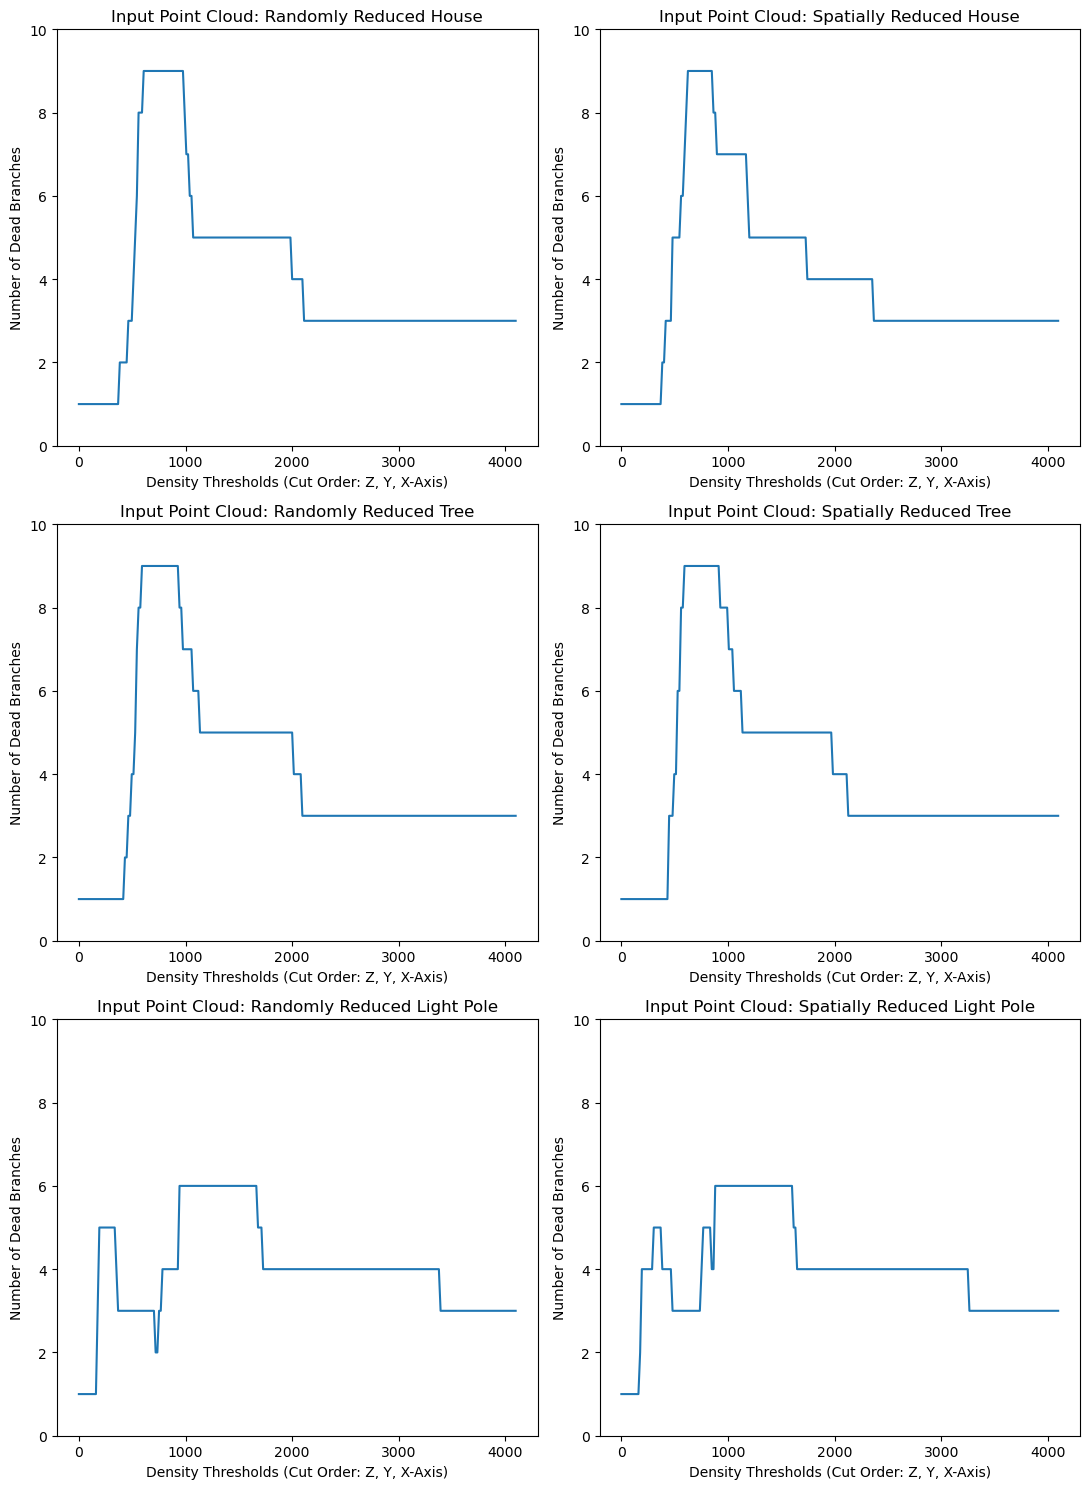

In [20]:
# Determine the global min and max y-values

# min_val = min([min(house_random_betti_0s), min(house_spatial_betti_0s), \
#            min(tree_random_betti_0s), min(tree_spatial_betti_0s), \
#            min(lightpole_random_betti_0s), min(lightpole_random_betti_0s)])
min_val = 0

# max_val = max([max(house_random_betti_0s), max(house_spatial_betti_0s), \
#            max(tree_random_betti_0s), max(tree_spatial_betti_0s), \
#            max(lightpole_random_betti_0s), max(lightpole_random_betti_0s)])
max_val = 10

# Create plot

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 15))

# Plot for House Random
axs[0,0].plot(density_thresholds, house_random_betti_0s)
axs[0,0].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[0,0].set_ylabel('Number of Dead Branches')
axs[0,0].set_ylim(min_val, max_val)
axs[0,0].set_title('Input Point Cloud: Randomly Reduced House')

# Plot for House Spatial
axs[0,1].plot(density_thresholds, house_spatial_betti_0s)
axs[0,1].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[0,1].set_ylabel('Number of Dead Branches')
axs[0,1].set_ylim(min_val, max_val)
axs[0,1].set_title('Input Point Cloud: Spatially Reduced House')

# Plot for Tree Random
axs[1,0].plot(density_thresholds, tree_random_betti_0s)
axs[1,0].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[1,0].set_ylabel('Number of Dead Branches')
axs[1,0].set_ylim(min_val, max_val)
axs[1,0].set_title('Input Point Cloud: Randomly Reduced Tree')

# Plot for Tree Spatial
axs[1,1].plot(density_thresholds, tree_spatial_betti_0s)
axs[1,1].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[1,1].set_ylabel('Number of Dead Branches')
axs[1,1].set_ylim(min_val, max_val)
axs[1,1].set_title('Input Point Cloud: Spatially Reduced Tree')

# Plot for Light Pole Random
axs[2,0].plot(density_thresholds, lightpole_random_betti_0s)
axs[2,0].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[2,0].set_ylabel('Number of Dead Branches')
axs[2,0].set_ylim(min_val, max_val)
axs[2,0].set_title('Input Point Cloud: Randomly Reduced Light Pole')

# Plot for Light Pole Spatial
axs[2,1].plot(density_thresholds, lightpole_spatial_betti_0s)
axs[2,1].set_xlabel('Density Thresholds (Cut Order: Z, Y, X-Axis)')
axs[2,1].set_ylabel('Number of Dead Branches')
axs[2,1].set_ylim(min_val, max_val)
axs[2,1].set_title('Input Point Cloud: Spatially Reduced Light Pole')

plt.tight_layout()
plt.show()

### Comparison Among Z-Score Normalized Varainces in Deterministic K-D Tree

In [21]:
var = np.array([var_house_random, var_house_spatial, \
                var_tree_random, var_tree_spatial, \
                var_lightpole_random, var_lightpole_spatial])
var_normal = (var - np.mean(var)) / np.std(var)

print(abs(var_normal))

[0.78513148 0.38970812 0.81741653 0.80569724 1.39166923 1.40628414]


### Normalized Variances of the Deterministic K-D Trees Cut in x-, y-, z- axis Order

| Input Data |Variances|
| -| - |
| House (Random)  | 0.83210852  |
| House (Spatial) | 0.73674147  |
| Tree (Random) | 0.61816496  |
| Tree (Spatial) | 0.6334594   |
| Light Pole (Random) | 1.45423099  |
| Light Pole (Spatial) | 1.36624336  |

### Normalized Variances of the Deterministic K-D Trees Cut in z-, y-, x- axis Order

| Input Data |Variances|
| -| - |
| House (Random)  | 0.78513148  |
| House (Spatial) | 0.38970812  |
| Tree (Random) | 0.81741653  |
| Tree (Spatial) | 0.80569724  |
| Light Pole (Random) | 1.39166923   |
| Light Pole (Spatial) | 1.40628414  |

### Comparison Among Z-Score Normalized Wasserstein Distances in Determistic K-D Tree

In [22]:
was_dis = np.array([was_dis_house, was_dis_tree, was_dis_lightpole])

was_dis_normal = (was_dis - np.mean(was_dis)) / np.std(was_dis)

print(abs(was_dis_normal))

[1.40223371 0.54203992 0.86019379]


### Normalized Wasserstein Distances of the Deterministic K-D Trees Cut in X, Y, Z-axis Order

| Input Data |Wasserstein Distances|
| -| - |
| House | 0.37876576  |
| Tree | 0.99061813  |
| Light Pole | 1.36938388  |

### Normalized Wasserstein Distances of the Deterministic K-D Trees Cut in Z, Y, X-axis Order

| Input Data |Wasserstein Distances|
| -| - |
| House | 1.40223371  |
| Tree | 0.54203992  |
| Light Pole | 0.86019379  |

### Export Files for Visualization in Gephi

In [21]:
# kdtree_df = pd.DataFrame(kdtree, columns=['Degree', 'Depth', 'Source', 'Target'])

# # Edge
# # Source,Target,Type

# kdtree_df_edge = kdtree_df[['Source', 'Target']].copy()
# kdtree_df_edge['Type'] = 'Directed'

# # Node
# # Id,Degree(num_point),Depth

# kdtree_df_node = kdtree_df[['Target', 'Degree', 'Depth']]
# kdtree_df_node = kdtree_df_node.rename(columns={'Target': 'Id'})
# kdtree_df_node.loc[len(kdtree_df_node)] = {'Id': 0, 'Degree': 4096, 'Depth': 0} # append root node

# # export CSV

# kdtree_df_edge.to_csv('edge.csv', index = False)
# kdtree_df_node.to_csv('node.csv', index = False)